# TOC entitlements near bus/rail lines
* Which bus/rail lines or rail stations have seen the most TOC entitlement activity?
* Which ones have seen lots of non-TOC entitlement activity? 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import intake
import boto3

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

In [18]:
metro_rail_stations = catalog.metro_rail_stations.read()
metrolink_stations = catalog.metrolink_stations.read()
metro_bus_stops = catalog.metro_bus_stops.read()
toc_tiers = gpd.read_file(f's3://{bucket_name}/gis/raw/TOC_Tiers.geojson').to_crs({'init':'epsg:4326'})
intersections = catalog.street_intersections.read().to_crs({'init':'epsg:4326'})
metro_bus_lines = catalog.metro_bus_lines.read().to_crs({'init':'epsg:4326'})

In [14]:
# Save all the dfs that need to be clipped by TOC Tiers into dictionary
dataframes = {'metro_rail_stations': metro_rail_stations, 
             'metrolink_stations': metrolink_stations,
             'metro_bus_stops': metro_bus_stops}

clipped_dfs = {}

# Clip to TOC Tiers, better than clipping to city boundary, because this gets rid of more
# Would use gpd.clip, but our geopandas is an older version
for key, value in dataframes.items():
    display(key)
    print(f'{len(value)}')
    clipped = gpd.sjoin(value, toc_tiers, how = 'inner', op = 'intersects')
    clipped_dfs[key] = clipped
    print(f'{len(clipped)}')

'metro_rail_stations'

96
57


'metrolink_stations'

58
10


'metro_bus_stops'

13974
5474


In [29]:
metro_bus_stops.sort_values('STOPNUM').head()

,STOPNUM,STOPNAME,LAT,LONG,LINE_DIR_1,LINE_DIR_2,LINE_DIR_3,LINE_DIR_4,LINE_DIR_5,LINE_DIR_6,...,LINE_DIR_A,LINE_DIR_B,LINE_DIR_C,LINE_DIR_D,LINE_DIR_E,LINE_DIR_F,LINE_DIR_G,LINE_DIR_H,LINE_DIR_I,geometry
0,1,PARAMOUNT / SLAUSON,33.973248,-118.113113,108-E,265-S,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.11311 33.97325)
1,3,JEFFERSON / 10TH,34.025471,-118.328402,35-N,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.32840 34.02547)
2,6,120TH \ AUGUSTUS F HAWKINS,33.924696,-118.242222,55-N,120-W,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.24222 33.92470)
3,7,120TH \ MARTIN LUTHER KING HOSPITAL,33.924505,-118.240369,55-S,120-E,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.24037 33.92451)
4,8,120TH / CRENSHAW,33.923818,-118.326886,126-E,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.32689 33.92382)


In [30]:
metro_bus_lines.sort_values('STOPNUM').head()

,STOPNUM,LINE,DIR_A2,STOPNAME,LAT,LONG,geometry
0,1,108,E,PARAMOUNT / SLAUSON,33.973248,-118.113113,POINT (-118.11311 33.97325)
1,1,265,S,PARAMOUNT / SLAUSON,33.973248,-118.113113,POINT (-118.11311 33.97325)
2,3,35,N,JEFFERSON / 10TH,34.025471,-118.328402,POINT (-118.32840 34.02547)
3,6,55,N,120TH \ AUGUSTUS F HAWKINS,33.924696,-118.242222,POINT (-118.24222 33.92470)
4,6,120,W,120TH \ AUGUSTUS F HAWKINS,33.924696,-118.242222,POINT (-118.24222 33.92470)


In [17]:
metro_rail = clipped_dfs['metro_rail_stations']
metrolink = clipped_dfs['metrolink_stations']
metro_bus = clipped_dfs['metro_bus_stops']

In [21]:
metro_bus_lines.sort_values('LINE').head()

,STOPNUM,LINE,DIR_A2,STOPNAME,LAT,LONG,geometry
15414,16300,2,W,SUNSET \ CLARK,34.090771,-118.385368,POINT (-118.38537 34.09077)
15472,16343,2,W,SUNSET / SWEETZER,34.096477,-118.370828,POINT (-118.37083 34.09648)
15473,16345,2,W,SUNSET / VIRGIL,34.098294,-118.287736,POINT (-118.28774 34.09829)
15475,16346,2,W,SUNSET / WESTERN,34.098235,-118.309566,POINT (-118.30957 34.09824)
15477,16348,2,W,SUNSET / WILTON,34.098222,-118.313431,POINT (-118.31343 34.09822)


In [24]:
high_frequency_lines = metro_bus_lines[metro_bus_lines.LINE >= 700]

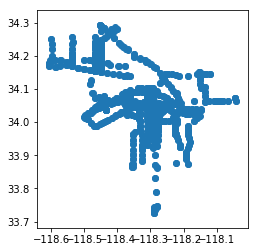

In [26]:
high_frequency_lines.plot()

In [4]:
keep = ['ASSETID', 'CL_NODE_ID', 'FROM_ST', 'TO_ST', 'TRANSIT', 'TRANSITSTOP', 'geometry']
intersections = intersections[keep]

In [5]:
# This seems ok, it's possible that the intersection isn't a transit stop, but there's a stop 100ft away?
intersections[intersections.TRANSIT==0].TRANSITSTOP.value_counts()

0.0    9044
1.0       4
Name: TRANSITSTOP, dtype: int64

In [6]:
# Shouldn't all these be TRANSITSTOP >= 1? Why are there zeroes?
intersections[intersections.TRANSIT==1].TRANSITSTOP.value_counts()

0.0    28110
1.0     1846
2.0     1609
3.0      280
4.0      209
5.0       47
6.0       26
7.0        7
8.0        1
Name: TRANSITSTOP, dtype: int64

## Find ways to pare down intersections
* spatial join to TOC Tiers
* run the high frequency bus lines through them (with buffers around intersections)

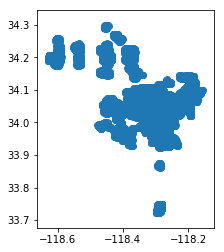

In [7]:
test = gpd.sjoin(intersections, toc_tiers, how = 'inner', op = 'intersects')
test.plot()

In [8]:
print(f'# obs in intersections: {len(intersections)}')
print(f'# obs in clipped intersections: {len(test)}')

# obs in intersections: 41183
# obs in clipped intersections: 16487
